In [1]:
# Increase discplay size of jupyter notebook cells
from IPython.display import display, HTML
display(HTML("<style> div#notebook-container { width: 80%; }  </style> "))

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [3]:
# Download external data

df = pd.read_csv('https://raw.githubusercontent.com/dimitris1ps/data/master/etic_refined.csv')

In [4]:
# Work is our L0 metric
df = df[['Work', 'Post_Period', 'Treatment_Group', 'Nonwhite', 'Finc', 'Earn', 'Age', 'Ed', 'Unearn', 'Urate', 'Year']]

In [5]:
df.sample(5)

,Work,Post_Period,Treatment_Group,Nonwhite,Finc,Earn,Age,Ed,Unearn,Urate,Year
11811,0,1,1,0,10605.889100,0.000000,21,7,10.605889,4.6,1996
4537,1,0,1,1,5385.844619,2859.942979,28,9,2.525902,7.7,1992
5334,0,0,1,0,5944.608997,0.000000,23,7,5.944609,6.9,1993
2144,1,0,0,1,43778.083700,43601.321590,54,10,0.176762,6.7,1991
7956,0,1,0,1,11917.287450,0.000000,42,11,11.917287,6.8,1994


<b>`Work`</b> is the metric we will explore for a significant difference after the intervention which happend in `1994`

Differences between `Test` and `Control` group might be also attributed to difference in the other (confounding) variables such are Unearn, Age, Earn etc.

### Explore

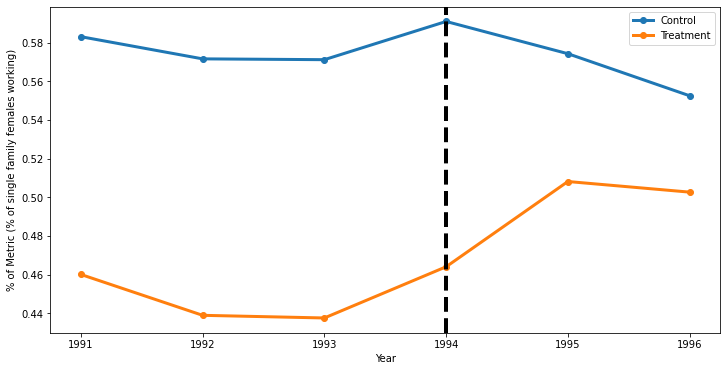

In [6]:
tmp = df.groupby(['Year', 'Treatment_Group'])[['Work']].mean().unstack()
tmp.columns = ['Control', 'Treatment']

ax = tmp.plot(figsize=(12, 6), style='o-', lw=3)
ax.axvline(1994, color='k', linestyle='--', lw=4, label='Intervention')
ax.set_ylabel("% of Metric (% of single family females working)");

### Compute effect

The formula is:<b> $\langle  \text{Difference in Post Period} - \text{Difference in Pre Period}\rangle $ </b> i.e <b>Diff in Diff</b><br>of the average metric value

In [7]:
df_effect = df.groupby(['Treatment_Group', 'Post_Period'])[['Work']].mean().unstack(level=0)
df_effect.columns = ['Control', 'Treatment']
df_effect.index  = ['Pre', 'Post']

In [8]:
df_effect['diff'] = df_effect['Treatment'] - df_effect['Control']

In [9]:
df_effect

,Control,Treatment,diff
Pre,0.575460,0.445962,-0.129498
Post,0.573386,0.490761,-0.082625


In [10]:
did = df_effect.loc[df_effect.index=='Post', 'diff'][0] - df_effect.loc[df_effect.index=='Pre', 'diff'][0] # did: diff in diff

In [11]:
did

0.04687313210185562

So the calulated lift is 0.046 or 4.6%

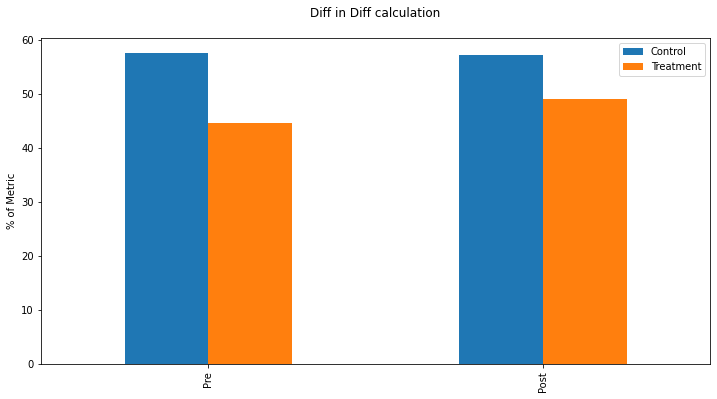

In [12]:
ax = (df_effect[['Control', 'Treatment']] * 100).plot(kind='bar', figsize=(12,6), title='Diff in Diff calculation\n')
ax.set_ylabel("% of Metric");

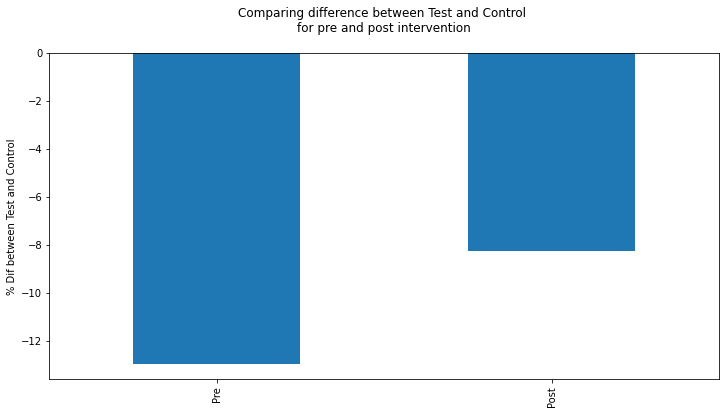

In [13]:
ax = (df_effect['diff'] * 100 ).plot(kind='bar', figsize=(12,6), title='Comparing difference between Test and Control \nfor pre and post intervention\n')
ax.set_ylabel("% Dif between Test and Control");

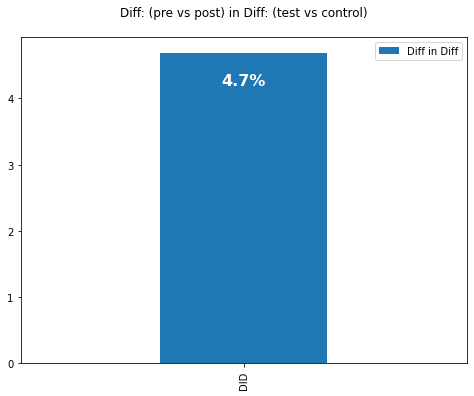

In [14]:
ax = pd.DataFrame({'Diff in Diff':[ did * 100]}, index=['DID']).\
    plot(kind='bar',  title='Diff: (pre vs post) in Diff: (test vs control)\n', figsize=(8,6), width=0.3)
ax.annotate(f'{round(did*100, 1)}%', (-0.04, round(did*100, 1)-0.5), size=16,  weight='bold', color='white');

### Regression estimation

We can also calculate the Diff in Diff with a linear regression using only the $Metric$, the $TreatmentVar$ and the $ProPostPeriodVar$

In [15]:
df[['Work', 'Post_Period', 'Treatment_Group']].head(5)

,Work,Post_Period,Treatment_Group
0,1,0,0
1,1,0,1
2,0,0,1
3,0,0,0
4,1,0,1


$Work = b_0 + b_1 * Post\_Period + b_2 * Treatment\_Group + b_3 * (Post\_Period * Treatment\_Group)$

Notice the Treatment group and the Post period need to be recoded as `1`, Pre period and Contol group as `0`

In [16]:
tmp = df[['Work', 'Post_Period', 'Treatment_Group']].copy()
tmp['Interaction'] = tmp['Post_Period'] * tmp['Treatment_Group'] # this is the group we are interested in, i.e. After treatment date for the treatment group

In [17]:
X = tmp[['Post_Period', 'Treatment_Group', 'Interaction']]
X = sm.add_constant(X)

y = tmp['Work']

# Note the difference in argument order
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Work   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     58.45
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           1.54e-37
Time:                        20:09:12   Log-Likelihood:                -9884.9
No. Observations:               13746   AIC:                         1.978e+04
Df Residuals:                   13742   BIC:                         1.981e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5755      0.009     65.060      0.000       0.558       0.593
Post_Period        -0.0021      0.013     -0.160      0.873      -0.027       0.023
Treatment_Group    -0.1295      0.012    -11.091      0.000      -0.152      -0.107
Interaction         0.0469      0.017      2.732      0.006       0.013       0.081
==============================================================================
Omnibus:                    48666.260   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2175.929
Skew:                          -0.051   Prob(JB):                         0.00
Kurtosis:                       1.054   Cond. No.                         7.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice that we get exactly the same result i.e. the coefficient of the interaction term is the same as the effect we computed before

In [18]:
round(model.params['Interaction'], 5) == round(did, 5)

True

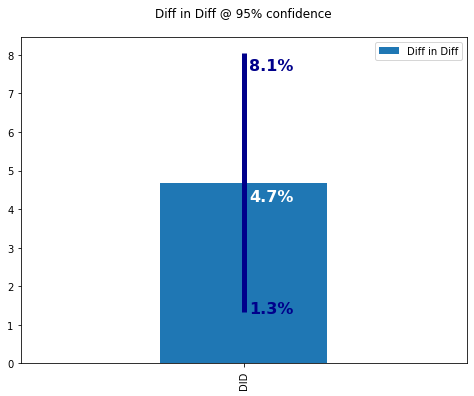

In [19]:
coeff = model.params['Interaction'] * 100
lower = model.conf_int().loc["Interaction"][0]*100
upper = model.conf_int().loc["Interaction"][1]*100


ax = pd.DataFrame({'Diff in Diff':[coeff]}, index=['DID']).plot(kind='bar', 
            yerr=[[coeff - lower]], 
            width=0.3, error_kw=dict(elinewidth=5,ecolor='darkblue'), 
            title='Diff in Diff @ 95% confidence\n', figsize=(8,6))

ax.annotate(f'{round(coeff, 1)}%', (0.01, round(coeff, 1)-0.5), size=16,  weight='bold', color='white')
ax.annotate(f'{round(lower, 1)}%', (0.01, round(lower, 1)), size=16,  weight='bold', color='darkblue')
ax.annotate(f'{round(upper, 1)}%', (0.01, round(upper-0.5, 1)), size=16,  weight='bold', color='darkblue');

### Include confounding effects



In [21]:
tmp = df[['Work', 'Post_Period', 'Treatment_Group', 'Nonwhite', 'Earn', 'Age', 'Ed', 'Unearn', 'Urate']].copy()
tmp['Interaction'] = tmp['Post_Period'] * tmp['Treatment_Group'] # this is the group we are interested in, i.e. After treatment date and the treatment group

In [22]:
# With linear regression
X = tmp[['Post_Period', 'Treatment_Group', 'Nonwhite', 'Earn', 'Age', 'Ed', 'Unearn', 'Urate', 'Interaction']]
X = sm.add_constant(X)

y = tmp['Work']

# Note the difference in argument order
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Work   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     369.3
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:09:23   Log-Likelihood:                -8482.8
No. Observations:               13746   AIC:                         1.699e+04
Df Residuals:                   13736   BIC:                         1.706e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4542      0.032     13.996      0.000       0.391       0.518
Post_Period        -0.0253      0.012     -2.054      0.040      -0.049      -0.001
Treatment_Group    -0.0535      0.011     -4.889      0.000      -0.075      -0.032
Nonwhite           -0.0533      0.008     -6.486      0.000      -0.069      -0.037
Earn              8.91e-06   2.13e-07     41.772      0.000    8.49e-06    9.33e-06
Age                 0.0027      0.000      6.878      0.000       0.002       0.004
Ed                  0.0131      0.001      8.796      0.000       0.010       0.016
Unearn             -0.0177      0.001    -32.594      0.000      -0.019      -0.017
Urate              -0.0144      0.003     -4.787      0.000      -0.020      -0.009
Interaction         0.0401      0.016      2.588      0.010       0.010       0.071
==============================================================================
Omnibus:                       49.288   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.765
Skew:                          -0.146   Prob(JB):                     1.56e-11
Kurtosis:                       2.959   Cond. No.                     1.82e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So the true lift is 0.0401 or <b>4.01%</b> (as seen from the beta coefficient in the regression results above). Notice also that `P value < 0.05` hence statistically significant

In [23]:
model.params['Interaction']

0.040134574661621264

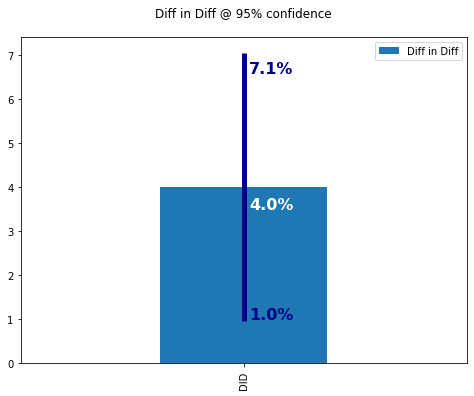

In [24]:
coeff = model.params['Interaction'] * 100
lower = model.conf_int().loc["Interaction"][0]*100
upper = model.conf_int().loc["Interaction"][1]*100


ax = pd.DataFrame({'Diff in Diff':[coeff]}, index=['DID']).plot(kind='bar', 
            yerr=[[coeff - lower]], 
            width=0.3, error_kw=dict(elinewidth=5,ecolor='darkblue'), 
            title='Diff in Diff @ 95% confidence\n', figsize=(8,6))

ax.annotate(f'{round(coeff, 1)}%', (0.01, round(coeff, 1)-0.5), size=16,  weight='bold', color='white')
ax.annotate(f'{round(lower, 1)}%', (0.01, round(lower, 1)), size=16,  weight='bold', color='darkblue')
ax.annotate(f'{round(upper, 1)}%', (0.01, round(upper-0.5, 1)), size=16,  weight='bold', color='darkblue');

### Placebo

Besides the p value, we need to run a placebo test to further verify that we can trust our results. What we want with the placebo is to find <b>No significance </b>in the new Interation variable that we are going to create

<b>How</b>: Arbitrarily choose a treatment time before your actual treatment time, and test to see if you get a significant treatment effect.

In [25]:
# sub set the data, including only years before the intervention date (1994).
df_sub = df[df['Year'] <= 1993].copy()

In [26]:
# Create a new intervention date say 1992
df_sub['Post_Period'] = np.select([df_sub['Year']>=1992], [1], default=0)

In [27]:
tmp = df_sub[['Work', 'Post_Period', 'Treatment_Group']].copy()
tmp['Interaction'] = tmp['Post_Period'] * tmp['Treatment_Group']

In [28]:
df_effect = tmp.groupby(['Treatment_Group', 'Post_Period'])[['Work']].mean().unstack(level=0)
df_effect.columns = ['Control', 'Treatment']
df_effect.index  = ['Pre', 'Post']

In [29]:
df_effect['diff'] = df_effect['Treatment'] - df_effect['Control']

In [30]:
df_effect

,Control,Treatment,diff
Pre,0.583032,0.460053,-0.122979
Post,0.571359,0.438251,-0.133107


In [31]:
did_placebo = df_effect.loc[df_effect.index=='Post', 'diff'][0] - df_effect.loc[df_effect.index=='Pre', 'diff'][0] # did: diff in diff

In [32]:
did_placebo # close to zero

-0.01012815400006667

In [33]:
X = tmp[['Post_Period', 'Treatment_Group', 'Interaction']]
X = sm.add_constant(X)

y = tmp['Work']

# Note the difference in argument order
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Work   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     41.89
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           7.77e-27
Time:                        20:09:28   Log-Likelihood:                -5309.2
No. Observations:                7401   AIC:                         1.063e+04
Df Residuals:                    7397   BIC:                         1.065e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5830      0.015     39.132      0.000       0.554       0.612
Post_Period        -0.0117      0.018     -0.631      0.528      -0.048       0.025
Treatment_Group    -0.1230      0.020     -6.262      0.000      -0.161      -0.084
Interaction        -0.0101      0.024     -0.415      0.678      -0.058       0.038
==============================================================================
Omnibus:                    26607.726   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1151.244
Skew:                          -0.003   Prob(JB):                    1.02e-250
Kurtosis:                       1.068   Cond. No.                         8.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the interaction term is insignificant `p value > 0.05`. So we can trust our initial findings of a significant difference

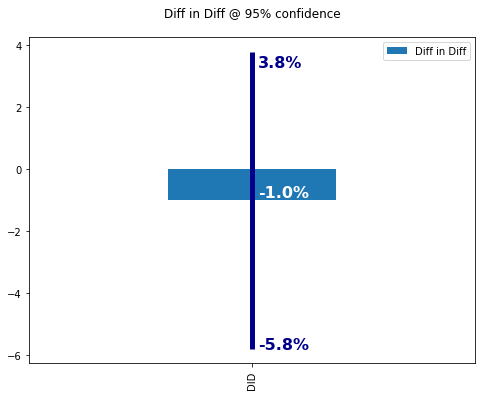

In [34]:
coeff = model.params['Interaction'] * 100
lower = model.conf_int().loc["Interaction"][0]*100
upper = model.conf_int().loc["Interaction"][1]*100


ax = pd.DataFrame({'Diff in Diff':[coeff]}, index=['DID']).plot(kind='bar', 
            yerr=[[coeff - lower]], 
            width=0.3, error_kw=dict(elinewidth=5,ecolor='darkblue'), 
            title='Diff in Diff @ 95% confidence\n', figsize=(8,6))

ax.annotate(f'{round(coeff, 1)}%', (0.01, round(coeff+0.1, 1)), size=16,  weight='bold', color='white')
ax.annotate(f'{round(lower, 1)}%', (0.01, round(lower, 1)), size=16,  weight='bold', color='darkblue')
ax.annotate(f'{round(upper, 1)}%', (0.01, round(upper-0.5, 1)), size=16,  weight='bold', color='darkblue');

### Placebo 2<sup>nd</sup> option

Alternatively, we could assign a random group as a treatment, and check to see if that we dont have a significance